In [1]:
import torch
import torchvision
from torchvision import transforms
from torchvision.datasets import ImageFolder


import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch

In [2]:
#train and test data directory
data_dir = "/home/harsh_1921cs01/hub/os/nl/VJH_020/data/lemon/train_image_10"
test_data_dir = "/home/harsh_1921cs01/hub/os/nl/VJH_020/data/lemon/test_image_10"

from torchvision.transforms.functional import crop
def crop800(image):
    return crop(image, 300, 300, 500, 500)

#load the train and test data
dataset = ImageFolder(data_dir,transform = transforms.Compose([
    transforms.Resize((1050,1050)), transforms.Lambda(crop800), transforms.ToTensor()
]))
test_dataset = ImageFolder(test_data_dir,transforms.Compose([
    transforms.Resize((1050,1050)), transforms.CenterCrop(600), transforms.ToTensor()
]))

In [3]:
img, label = dataset[80]
print(img.shape,label)

torch.Size([3, 500, 500]) 0


In [4]:
print("Follwing classes are there : \n",dataset.classes)

Follwing classes are there : 
 ['cat_0001', 'cat_0002', 'cat_0003', 'cat_0004', 'cat_0005', 'cat_0006', 'cat_0007', 'cat_0008', 'cat_0009', 'cat_0010']


Label : cat_0001


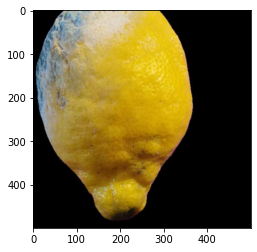

In [5]:
def display_img(img,label):
    print(f"Label : {dataset.classes[label]}")
    plt.imshow(img.permute(1,2,0))

#display the first image in the dataset
display_img(*dataset[95])

In [6]:
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split

batch_size = 32
val_size = 100
train_size = len(dataset) - val_size 

train_data,val_data = random_split(dataset,[train_size,val_size])
print(f"Length of Train Data : {len(train_data)}")
print(f"Length of Validation Data : {len(val_data)}")

#load the train and validation into batches.
train_dl = DataLoader(train_data, batch_size, shuffle = True, num_workers = 4, pin_memory = True)
val_dl = DataLoader(val_data, batch_size*2, num_workers = 4, pin_memory = True)


Length of Train Data : 875
Length of Validation Data : 100


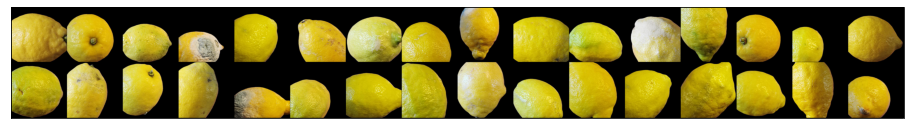

In [7]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

def show_batch(dl):
    """Plot images grid of single batch"""
    for images, labels in dl:
        fig,ax = plt.subplots(figsize = (16,12))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images,nrow=16).permute(1,2,0))
        break
        
show_batch(train_dl)

In [8]:
import torch.nn as nn
import torch.nn.functional as F

class ImageClassificationBase(nn.Module):
    
    def training_step(self, batch):
        images, labels = batch 
        print(images.shape)
        out = self(images)                  # Generate predictions
        print(out.shape)
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

In [9]:
class NaturalSceneClassification(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            
            nn.Conv2d(3, 256, kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.Conv2d(256,64, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
        
            nn.Conv2d(64, 128, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.Conv2d(128 ,128, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            
            nn.Conv2d(128, 256, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.Conv2d(256,256, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            
            nn.Flatten(),
            nn.Linear(1048576,1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512,10)
        )
    
    def forward(self, xb):
        return self.network(xb)
    
class Net(ImageClassificationBase):
    def __init__(self):
        super(Net, self).__init__()
        # number of hidden nodes in each layer (512)
        hidden_1 = 512
        hidden_2 = 512
        # linear layer (784 -> hidden_1)
        self.fc1 = nn.Linear(3 * 1050 * 1050, hidden_1)
        # linear layer (n_hidden -> hidden_2)
        self.fc2 = nn.Linear(hidden_1, hidden_2)
        # linear layer (n_hidden -> 10)
        self.fc3 = nn.Linear(hidden_2, 10)
        # dropout layer (p=0.2)
        # dropout prevents overfitting of data
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        # flatten image input
        x = x.view(-1, 1050 * 1050 * 3)
        # add hidden layer, with relu activation function
        x = F.relu(self.fc1(x))
        # add dropout layer
        x = self.dropout(x)
        # add hidden layer, with relu activation function
        x = F.relu(self.fc2(x))
        # add dropout layer
        x = self.dropout(x)
        # add output layer
        x = self.fc3(x)
        return x  
    
class LemonNet(ImageClassificationBase):
    def __init__(self,xDim,yDim,numC): 
        super(LemonNet,self).__init__()
        
        numConvs1 = 5
        convSize1 = 7
        numConvs2 = 10
        convSize2 = 7
        numNodesToFC = numConvs2*(xDim-(convSize1-1)-(convSize2-1))*(yDim-(convSize1-1)-(convSize2-1))
        
        self.cnv1 = nn.Conv2d(3, numConvs1, convSize1)
        self.cnv2 = nn.Conv2d(numConvs1, numConvs2, convSize2)
        
        fcSize1 = 400
        fcSize2 = 80
        
        self.ful1 = nn.Linear(numNodesToFC,fcSize1)
        self.ful2 = nn.Linear(fcSize1, fcSize2)
        self.ful3 = nn.Linear(fcSize2,numC)
        
    def forward(self,x):
        
        x = F.elu(self.cnv1(x))
        x = F.elu(self.cnv2(x))
        x = x.view(-1,self.num_flat_features(x))
        x = F.elu(self.ful1(x))
        x = F.elu(self.ful2(x))
        x = self.ful3(x)       
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        return num_features    
    
model = LemonNet(500, 500, 10)

In [10]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

  
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

  
def fit(epochs, lr, model, train_loader, val_loader, opt_func = torch.optim.SGD):
    
    history = []
    optimizer = opt_func(model.parameters(),lr)
    for epoch in range(epochs):
        
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    
    return history

In [ ]:
num_epochs = 30
opt_func = torch.optim.Adam
lr = 0.001
#fitting the model on training data and record the result after each epoch
history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

torch.Size([32, 3, 500, 500])
torch.Size([32, 10])
torch.Size([32, 3, 500, 500])
torch.Size([32, 10])
torch.Size([32, 3, 500, 500])
torch.Size([32, 10])
torch.Size([32, 3, 500, 500])
torch.Size([32, 10])
torch.Size([32, 3, 500, 500])
torch.Size([32, 10])
torch.Size([32, 3, 500, 500])
torch.Size([32, 10])
torch.Size([32, 3, 500, 500])
torch.Size([32, 10])
torch.Size([32, 3, 500, 500])
torch.Size([32, 10])
torch.Size([32, 3, 500, 500])
torch.Size([32, 10])
torch.Size([32, 3, 500, 500])
torch.Size([32, 10])
torch.Size([32, 3, 500, 500])
torch.Size([32, 10])
torch.Size([32, 3, 500, 500])
torch.Size([32, 10])
torch.Size([32, 3, 500, 500])
torch.Size([32, 10])
torch.Size([32, 3, 500, 500])
torch.Size([32, 10])
torch.Size([32, 3, 500, 500])
torch.Size([32, 10])
torch.Size([32, 3, 500, 500])
torch.Size([32, 10])
torch.Size([32, 3, 500, 500])
torch.Size([32, 10])
torch.Size([32, 3, 500, 500])
torch.Size([32, 10])
torch.Size([32, 3, 500, 500])
torch.Size([32, 10])
torch.Size([32, 3, 500, 500])
t

torch.Size([32, 10])
torch.Size([32, 3, 500, 500])
torch.Size([32, 10])
torch.Size([32, 3, 500, 500])
torch.Size([32, 10])
torch.Size([32, 3, 500, 500])
torch.Size([32, 10])
torch.Size([32, 3, 500, 500])
torch.Size([32, 10])
torch.Size([32, 3, 500, 500])
torch.Size([32, 10])
torch.Size([32, 3, 500, 500])
torch.Size([32, 10])
torch.Size([32, 3, 500, 500])
torch.Size([32, 10])
torch.Size([32, 3, 500, 500])
torch.Size([32, 10])
torch.Size([32, 3, 500, 500])
torch.Size([32, 10])
torch.Size([32, 3, 500, 500])
torch.Size([32, 10])
torch.Size([32, 3, 500, 500])
torch.Size([32, 10])
torch.Size([32, 3, 500, 500])
torch.Size([32, 10])
torch.Size([11, 3, 500, 500])
torch.Size([11, 10])
Epoch [5], train_loss: 0.8380, val_loss: 1.2437, val_acc: 0.5590
torch.Size([32, 3, 500, 500])
torch.Size([32, 10])
torch.Size([32, 3, 500, 500])
torch.Size([32, 10])
torch.Size([32, 3, 500, 500])
torch.Size([32, 10])
torch.Size([32, 3, 500, 500])
torch.Size([32, 10])
torch.Size([32, 3, 500, 500])
torch.Size([32, 1